In [1]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import torch
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

In [8]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
import yfinance as yf
import random
from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
#from tensorflow.keras.utils import to_categorical # for one-hot encoding
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [38]:
series[:5]-

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [39]:
series = pd.Series(range(10))
r = series.rolling(window=5)
m = r.mean().shift(1)
s = r.std(ddof=1).shift(1)
z = (series-m)/s

m = series[:5].mean()
s = series[:5].std(ddof=1)
z[:5] = (series[:5]-m)/s

In [4]:
class load_dataset(Dataset):
    def __init__(
        self,
        sample_size=None,
        batch_size=8,
        test_porportion=0.2,
        verbose=False,
        is_normalise=True,
        data_mode='train', augment_times=None
    ):
        self.sample_size = sample_size
        self.test_proportion = test_porportion
        self.input_size = 1
        self.output_size = 42
        self.verbose = verbose
        self.data_mode = data_mode
        self.is_normalise = is_normalise
        self.scaler = None
        
        start_date = '1999-01-01'
        
        # Get & preprocess data
        close = yf.download('SPY', start=start_date)['Adj Close']
        close.index = pd.to_datetime(close.index)
        vix = yf.Ticker('^VIX').history(start=start_date)['Close']
        vix.index = pd.to_datetime(vix.index.tz_convert(None).normalize())
        self.df = pd.DataFrame(index=close.index)
        self.df['close'] = close
        self.df['logreturns'] = np.log(close).diff()
        self.df['vix'] = vix
        
        # Incorporate BBG data
        ivol = pd.read_csv('data/ivol.csv', index_col='Date')['ivol']
        ivol.index = pd.to_datetime(ivol.index, format='%d/%m/%Y')
        pc_ratio = pd.read_csv('data/putcall_ratio.csv', index_col='Date')['putcall_ratio']
        pc_ratio.index = pd.to_datetime(pc_ratio.index, format='%d/%m/%Y')
        self.df['ivol'] = ivol
        self.df['pc_ratio'] = pc_ratio
        self.df.dropna(inplace=True)
        # Extract variables from self.df
        self.logreturns = np.array(self.df['logreturns'])
        self.conditions = np.concatenate([np.reshape(self.df[col], (-1,1)) for col in ['close','vix']], axis=1)

In [9]:
batch_size = 16
num_workers = 8
augment_times = None

train_set = load_dataset(is_normalise=True, data_mode='Train', augment_times=augment_times)

[*********************100%%**********************]  1 of 1 completed


In [16]:
train_set.df

,close,logreturns,vix,ivol,pc_ratio
Date,,,,,
2005-01-03,83.364349,-0.004727,14.08,12.9604,2.5506
2005-01-04,82.345695,-0.012295,13.98,13.0911,2.1629
2005-01-05,81.777451,-0.006925,14.09,13.2074,1.3774
2005-01-06,82.193237,0.005071,13.58,12.6558,1.2098
2005-01-07,82.075424,-0.001434,13.49,12.5318,1.2533
...,...,...,...,...,...
2023-12-22,472.182892,0.002008,13.03,12.7291,1.3211
2023-12-26,474.176697,0.004214,12.99,12.4668,1.3960
2023-12-27,475.034058,0.001806,12.43,11.9421,1.3262


rolling zscore vs rsi

<Axes: xlabel='Date'>

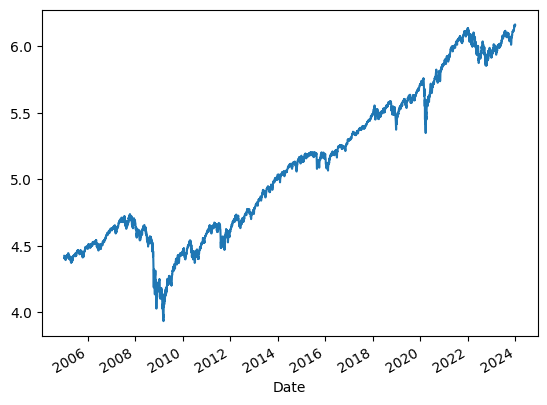

In [51]:
np.log(train_set.df.close).plot()
# 63d zscore
# 11d rsi, 252d zscore

<Axes: xlabel='Date'>

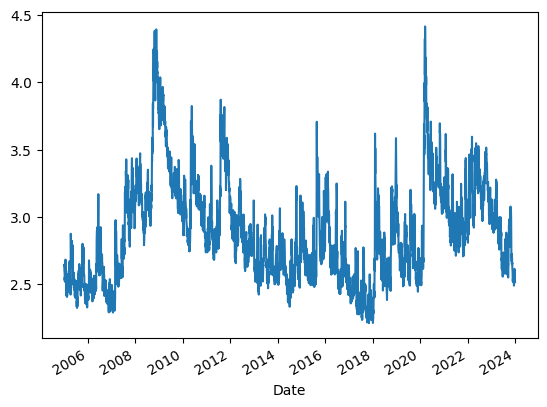

In [48]:
np.log(train_set.df.vix).plot()
# 252d zscore
# 42d zscore

<Axes: xlabel='Date'>

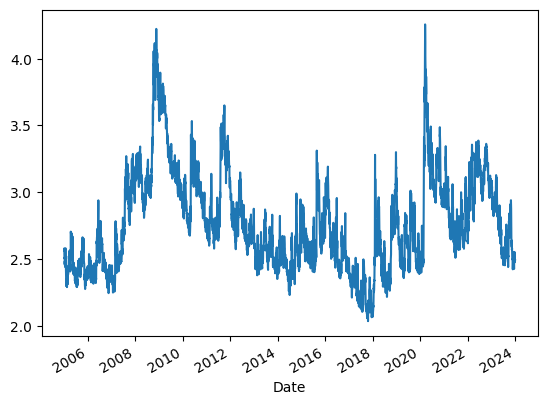

In [47]:
np.log(train_set.df.ivol).plot()
# 252d zscore
# 42d zscore

<Axes: xlabel='Date'>

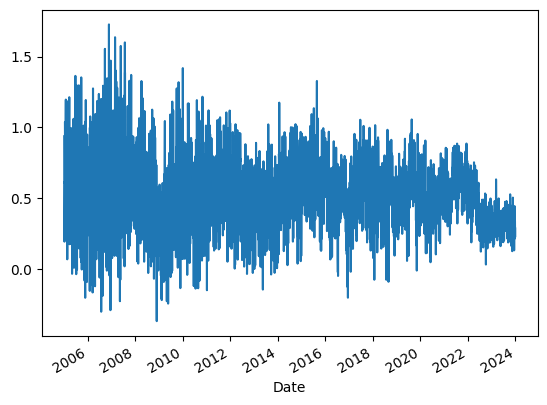

In [67]:
np.log(train_set.df.pc_ratio).plot()
# 252d zscore
# 42d zscore